In [18]:
# referenced code here: https://machinelearningmastery.com/develop-arch-and-garch-models-for-time-series-forecasting-in-python/
# also found this interesting https://medium.com/@phindulo60/portfolio-optimization-with-python-mean-variance-optimization-mvo-and-markowitzs-efficient-64acb3b61ef6
# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

aapl = pd.read_csv("Dataset/Equities/AAPL.csv")
meta = pd.read_csv("Dataset/Equities/META.csv")
orcl = pd.read_csv("Dataset/Equities/ORCL.csv")
pep = pd.read_csv("Dataset/Equities/PEP.csv")

df_aapl = pd.DataFrame(data=aapl)
df_meta = pd.DataFrame(data=meta)
df_orcl = pd.DataFrame(data=orcl)
df_pep = pd.DataFrame(data=pep)
df_aapl.rename(columns={"Close": "aapl_close"}, inplace=True)
df_meta.rename(columns={"Close": "meta_close"}, inplace=True)
df_orcl.rename(columns={"Close": "orcl_close"}, inplace=True)
df_pep.rename(columns={"Close": "pep_close"}, inplace=True)
# print(df_aapl)

aapl_close = df_aapl["aapl_close"]
meta_close = df_meta["meta_close"]
orcl_close = df_orcl["orcl_close"]
pep_close = df_pep["pep_close"]


# print(aapl_close)
# print(meta_close)
# print(orcl_close)
assert aapl_close.shape == meta_close.shape == orcl_close.shape

date = pd.to_datetime(df_aapl["Date"])
portfolio = pd.DataFrame(date)
portfolio = portfolio.join(aapl_close)
portfolio = portfolio.join(meta_close)
portfolio = portfolio.join(orcl_close)
portfolio = portfolio.join(pep_close)
# print(portfolio)
# print(f"portfolio shape: {portfolio.shape}")

portfolio.set_index('Date', inplace=True)

In [19]:
num_entries, num_stocks = portfolio.shape
print(f"portfolio shape: {portfolio.shape}")
portfolio


portfolio shape: (2518, 4)


,aapl_close,meta_close,orcl_close,pep_close
Date,,,,
2014-05-27,22.343929,63.480000,41.910000,86.529999
2014-05-28,22.286072,63.509998,41.570000,87.070000
2014-05-29,22.692142,63.830002,42.200001,87.730003
2014-05-30,22.607143,63.299999,42.020000,88.330002
2014-06-02,22.451786,63.080002,41.970001,87.870003
...,...,...,...,...
2024-05-20,191.039993,468.839996,124.519997,180.309998
2024-05-21,192.350006,464.630005,124.629997,181.080002
2024-05-22,190.899994,467.779999,124.599998,182.089996


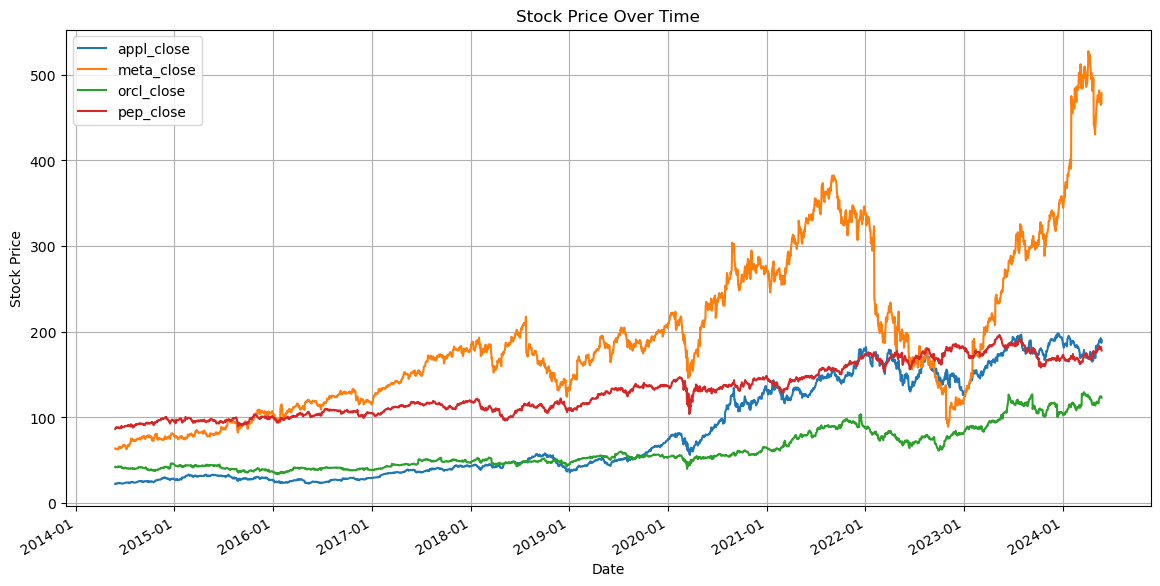

In [20]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(portfolio["aapl_close"], label="appl_close")
ax.plot(portfolio["meta_close"], label="meta_close")
ax.plot(portfolio["orcl_close"], label="orcl_close")
ax.plot(portfolio["pep_close"], label="pep_close")

ax.legend()

# Format x-ticks
ax.xaxis.set_major_locator(mdates.YearLocator())  # to display one tick per year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # to format the date as 'YYYY-MM'

# Rotate date labels automatically
fig.autofmt_xdate()

ax.set_title('Stock Price Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')
ax.grid(True)

plt.show()

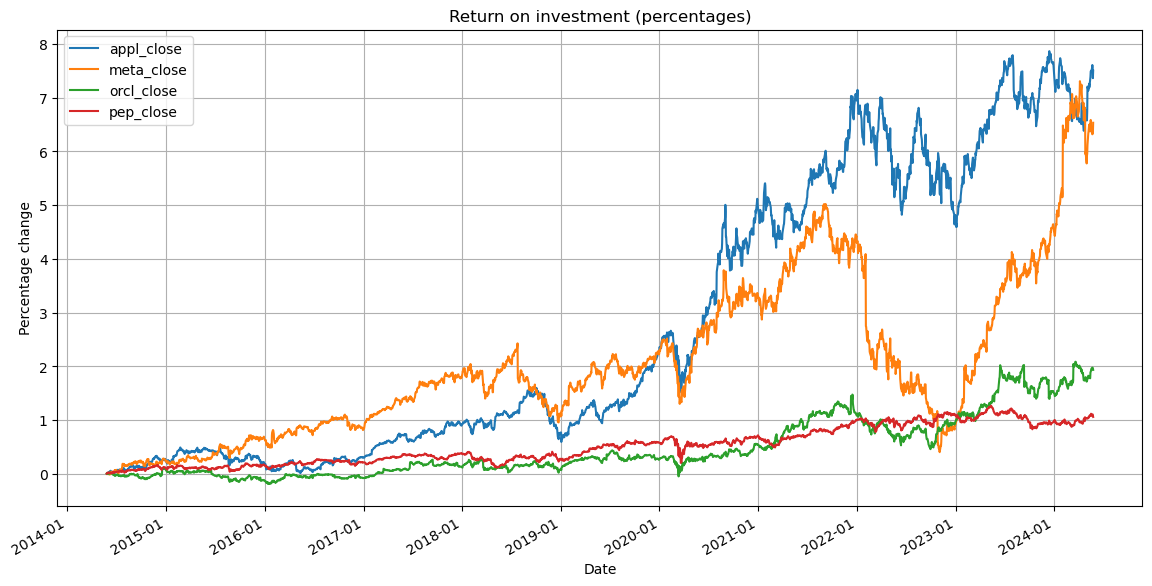

In [21]:
fig, ax = plt.subplots(figsize=(14, 7))
line1 = (portfolio["aapl_close"] - portfolio.iloc[(0, 0)]) / portfolio.iloc[(0, 0)]
line2 = (portfolio["meta_close"] - portfolio.iloc[(0, 1)]) / portfolio.iloc[(0, 1)]
line3 = (portfolio["orcl_close"] - portfolio.iloc[(0, 2)]) / portfolio.iloc[(0, 2)]
line4 = (portfolio["pep_close"] - portfolio.iloc[(0, 3)])/ portfolio.iloc[(0, 3)]
ax.plot(line1, label="appl_close")
ax.plot(line2, label="meta_close")
ax.plot(line3, label="orcl_close")
ax.plot(line4, label="pep_close")

ax.legend()

# Format x-ticks
ax.xaxis.set_major_locator(mdates.YearLocator())  # to display one tick per year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # to format the date as 'YYYY-MM'

# Rotate date labels automatically
fig.autofmt_xdate()

ax.set_title('Return on investment (percentages)')
ax.set_xlabel('Date')
ax.set_ylabel('Percentage change')
ax.grid(True)

plt.show()

## Mean-Variance optimization (forecast)

Below is an implementation of MVO with target weights. Currently experiencing some issue (giving a single stock weight of 0).

In [22]:
from scipy.optimize import minimize

# Assume we have price data in a pandas DataFrame called 'portfolio'
# returns are in percentage
returns = portfolio.pct_change()

print(f"returns shape: {returns.shape}")

#! Let's set a target return of 9.0 (900%)
target_return = 5.0

# Calculate mean returns and covariance matrix
#! 252 is used to annualize the data (252 trading days in the US)
mean_returns = returns.mean() * 252
# mean_returns = daily_returns_pct_change.mean()
cov_matrix = returns.cov() * 252

# Define the objective function (portfolio variance)
def objective(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Define the constraint (portfolio return should be equal to the target return)
def constraint1(weights):
    return np.sum(mean_returns * weights) - target_return

# Define the constraint (the sum of the weights should be equal to 1)
def constraint2(weights):
    return np.sum(weights) - 1


# Define the bounds and constraints for the optimization
bounds = tuple((0,1) for x in range(num_stocks))
constraints = ({'type': 'eq', 'fun': constraint1},
               {'type': 'eq', 'fun': constraint2})

# Perform the optimization
initial_weights = np.ones(num_stocks) /num_stocks

result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)

# Get the optimal portfolio weights
optimal_weights = result.x

returns shape: (2518, 4)


In [23]:
print(f"mean returns: {mean_returns}")
print(f"cov_matrix: {cov_matrix}")

mean returns: aapl_close    0.254529
meta_close    0.272802
orcl_close    0.142965
pep_close     0.089383
dtype: float64
cov_matrix:             aapl_close  meta_close  orcl_close  pep_close
aapl_close    0.080292    0.055899    0.035629   0.023088
meta_close    0.055899    0.139518    0.035887   0.019880
orcl_close    0.035629    0.035887    0.070855   0.020988
pep_close     0.023088    0.019880    0.020988   0.034252


(After Optim) initial portfolio values: 63.47999999999944
(After Optim) final portfolio values: 478.2200009999958


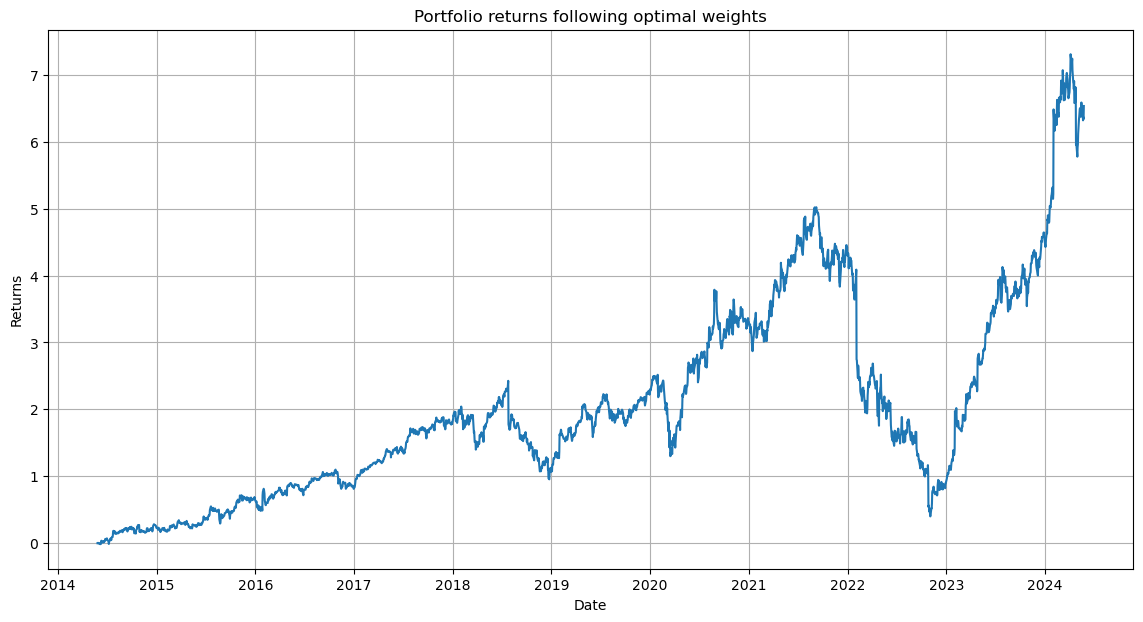

In [24]:
# print(f"num stocks: {num_stocks}")
# print(f"result type: {type(result)}")
# print(f"result: {result}")
# print(f"optimal_weights: {optimal_weights}")
# print(f"initial portfolio values: {portfolio.iloc[0, :]}")
# print(f"final portfolio values: {portfolio.iloc[-1, :]}")

#! setting too small values to zero
for i in range(len(optimal_weights)):
    if optimal_weights[i] < 1e-5:
        optimal_weights[i] = 0


portfolio_returns = np.dot(portfolio, optimal_weights)
portfolio_returns_pct_change = (portfolio_returns - portfolio_returns[0]) / portfolio_returns[0]
print(f"(After Optim) initial portfolio values: {portfolio_returns[0]}")
print(f"(After Optim) final portfolio values: {portfolio_returns[-1]}")

# Plot the portfolio returns

fig2, ax2 = plt.subplots(figsize=(14, 7))

ax2.plot(portfolio.index, portfolio_returns_pct_change)
ax2.set_title("Portfolio returns following optimal weights")
ax2.set_xlabel('Date')
ax2.set_ylabel('Returns')
ax2.grid(True)
plt.show()

## MVO w/ Risk aversion

It's roughly the same as MVO, but changed the multi-objective into a single objective, with a risk factor $\lambda$

In [25]:
# Risk aversion MVO

# Assume we have price data in a pandas DataFrame called 'portfolio'
# returns are in percentage
returns = portfolio.pct_change()

print(f"returns shape: {returns.shape}")

#! No target return, only how much risk the investor is willing to take
#! 0.0 is chasing max return without considering risk, 1.0 is minimizing risk
risk = 0.5

# Calculate mean returns and covariance matrix
#! 252 is used to annualize the data (252 trading days in the US)
mean_returns = returns.mean() * 252
print(f"mean_returns shape: {mean_returns.shape}")
# mean_returns = daily_returns_pct_change.mean()
cov_matrix = returns.cov() * 252
print(f"cov_matrix shape: {cov_matrix.shape}")

# Define the objective function (portfolio variance)
def objective(weights):
    return risk * np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) - (1 - risk) * np.sum(mean_returns * weights)


# Define the constraint (the sum of the weights should be equal to 1)
def constraint1(weights):
    return np.sum(weights) - 1


# Define the bounds and constraints for the optimization
bounds = tuple((0,1) for x in range(num_stocks))
constraints = ({'type': 'eq', 'fun': constraint1})

# Perform the optimization
initial_weights = np.ones(num_stocks) /num_stocks

result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)

# Get the optimal portfolio weights
optimal_weights_risk = result.x

returns shape: (2518, 4)
mean_returns shape: (4,)
cov_matrix shape: (4, 4)


(After Optim) initial portfolio values: 42.21361939472319
(After Optim) final portfolio values: 245.73302579867902


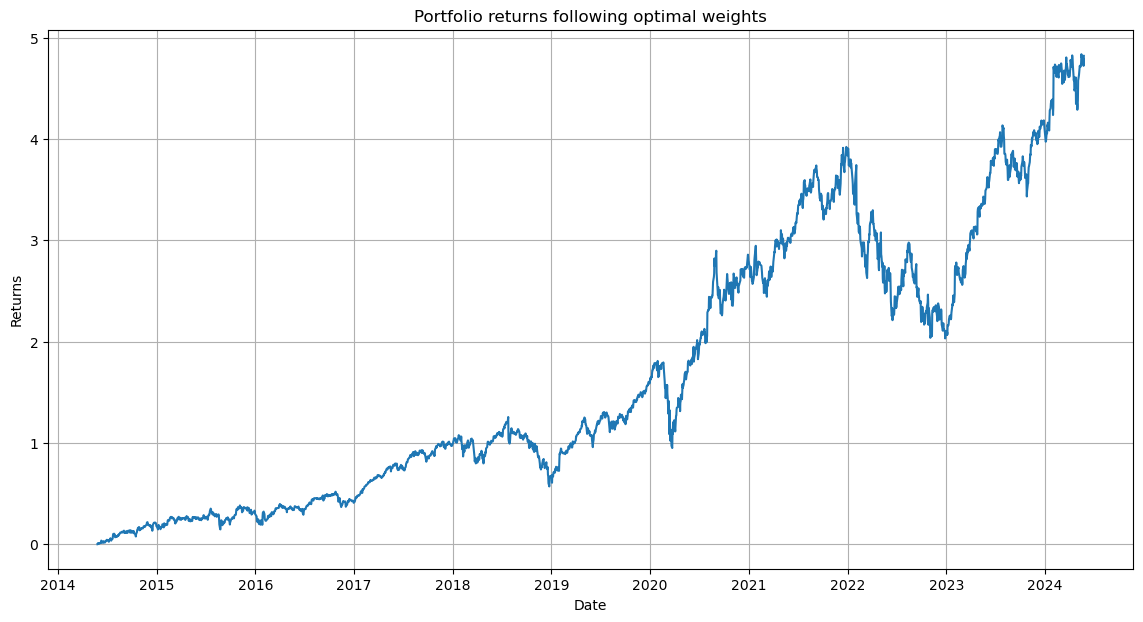

In [26]:
# print(f"optimal_weights: {optimal_weights_risk}")
# print(f"sum of weights: {np.sum(optimal_weights_risk)}")
# print(f"initial portfolio values: {portfolio.iloc[0, :]}")
# print(f"final portfolio values: {portfolio.iloc[-1, :]}")

#! setting too small values to zero
for i in range(len(optimal_weights)):
    if optimal_weights[i] < 1e-5:
        optimal_weights[i] = 0


portfolio_returns = np.dot(portfolio, optimal_weights_risk)
portfolio_returns_pct_change = (portfolio_returns - portfolio_returns[0]) / portfolio_returns[0]
print(f"(After Optim) initial portfolio values: {portfolio_returns[0]}")
print(f"(After Optim) final portfolio values: {portfolio_returns[-1]}")

# Plot the portfolio returns

fig2, ax2 = plt.subplots(figsize=(14, 7))

ax2.plot(portfolio.index, portfolio_returns_pct_change)
ax2.set_title("Portfolio returns following optimal weights")
ax2.set_xlabel('Date')
ax2.set_ylabel('Returns')
ax2.grid(True)
plt.show()

All MVO

In [27]:
import os
import pandas as pd

# Define the path to the folder containing the CSV files
folder_path = "Dataset/Equities/"

# Get a list of all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Initialize an empty list to store dataframes
dataframes = []

# Iterate through the CSV files and read them into dataframes
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    stock_name = file.split('.')[0].lower()  # Get stock name from the file name
    df.rename(columns={"Close": f"{stock_name}_close"}, inplace=True)  # Rename 'Close' column
    dataframes.append(df[['Date', f"{stock_name}_close"]])

# Merge all dataframes on the 'Date' column
portfolio = dataframes[0]
for df in dataframes[1:]:
    portfolio = portfolio.merge(df, on='Date')

# Convert 'Date' column to datetime format and set as index
portfolio['Date'] = pd.to_datetime(portfolio['Date'])
portfolio.set_index('Date', inplace=True)

# Print the shape of the portfolio and display it
num_entries, num_stocks = portfolio.shape
print(f"portfolio shape: {portfolio.shape}")
portfolio


portfolio shape: (2518, 39)


,ba_close,msbhf_close,v_close,hca_close,ntdoy_close,adm_close,lh_close,bac_close,irm_close,stz_close,...,dis_close,googl_close,meta_close,goog_close,jci_close,qcom_close,unh_close,aapl_close,lmt_close,brk-b_close
Date,,,,,,,,,,,,,,,,,,,,,
2014-05-27,134.169998,6.466667,53.625000,53.119999,2.870,44.320000,86.675255,15.220000,28.234751,83.449997,...,83.739998,28.743500,63.480000,28.220022,45.706806,80.459999,79.110001,22.343929,162.949997,127.519997
2014-05-28,134.330002,6.466667,53.450001,53.369999,2.854,44.290001,86.443298,15.140000,28.502773,83.150002,...,83.599998,28.522499,63.509998,28.007107,45.780106,80.220001,78.580002,22.286072,162.100006,127.459999
2014-05-29,135.139999,6.466667,53.667500,53.389999,2.908,44.639999,88.402061,15.150000,28.706100,83.779999,...,84.029999,28.528000,63.830002,27.927326,45.759163,80.190002,79.370003,22.692142,163.149994,128.110001
2014-05-30,135.250000,6.466667,53.707500,52.990002,2.912,44.939999,88.127151,15.140000,28.780037,84.129997,...,84.010002,28.582500,63.299999,27.917852,45.696335,80.449997,79.629997,22.607143,163.649994,128.339996
2014-06-02,135.899994,6.466667,53.380001,52.990002,2.904,44.849998,87.706184,15.260000,28.789280,83.940002,...,84.269997,28.216999,63.080002,27.620667,45.801048,80.480003,79.470001,22.451786,164.110001,127.879997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-20,186.610001,21.850000,278.540009,325.049988,13.380,60.869999,206.830002,38.820000,82.099998,250.559998,...,102.900002,176.919998,468.839996,178.460007,70.620003,197.759995,517.229980,191.039993,467.079987,413.000000
2024-05-21,184.779999,21.910000,275.950012,321.119995,13.440,61.270000,205.339996,39.650002,82.849998,250.979996,...,103.010002,177.850006,464.630005,179.539993,72.860001,200.850006,523.549988,192.350006,468.309998,414.369995
2024-05-22,186.279999,21.280001,275.579987,318.410004,13.330,61.900002,201.190002,39.759998,80.959999,248.940002,...,103.019997,176.380005,467.779999,178.000000,73.190002,202.929993,521.349976,190.899994,469.709991,413.989990


In [114]:
# Read the positions.csv file
positions_file = "Corporate Positions/Positions.csv"
positions = pd.read_csv(positions_file)

# Create a dictionary to store the quantity of each equity
equity_quantity = {}
for _, row in positions.iterrows():
    ticker = row['Symbol']
    quantity = row['Quantity']
    try:
        equity_quantity[ticker] = float(quantity.replace(',', ''))
    except:
        break


print(equity_quantity)

{'AAPL': 450.0, 'ADM': 110.0, 'ANET': 156.0, 'ARE': 55.0, 'BA': 33.0, 'BAC': 250.0, 'BRK-B': 50.0, 'CME': 35.0, 'DE': 13.0, 'DEO': 50.0, 'DIS': 140.0, 'DLR': 127.0, 'GOOG': 160.0, 'GOOGL': 220.0, 'GS': 36.0, 'HCA': 51.0, 'IPGP': 52.0, 'IRM': 456.0, 'JCI': 112.0, 'LH': 37.0, 'LMT': 16.0, 'LVMUY': 55.0, 'MCD': 50.0, 'MDLZ': 120.0, 'META': 30.0, 'MRK': 80.0, 'MSBHF': 1440.0, 'MSFT': 83.0, 'NTDOY': 1560.0, 'NVDA': 85.0, 'ORCL': 300.0, 'PEP': 137.0, 'PG': 113.0, 'PYPL': 131.0, 'QCOM': 75.0, 'SBUX': 80.0, 'STZ': 45.0, 'ULTA': 25.0, 'UNH': 116.0, 'V': 72.0, 'WFC': 220.0, 'BND': 905.7848, 'DJP': 348.0, 'EEM': 212.0, 'EFA': 608.0, 'INDA': 587.0, 'IXP': 150.0, 'VCIT': 558.0394, 'XLB': 128.0, 'XLE': 573.0, 'XLF': 356.0, 'XLI': 258.0, 'XLP': 153.0, 'XLU': 104.0, 'XLV': 190.0, 'VFSTX': 2556.2}


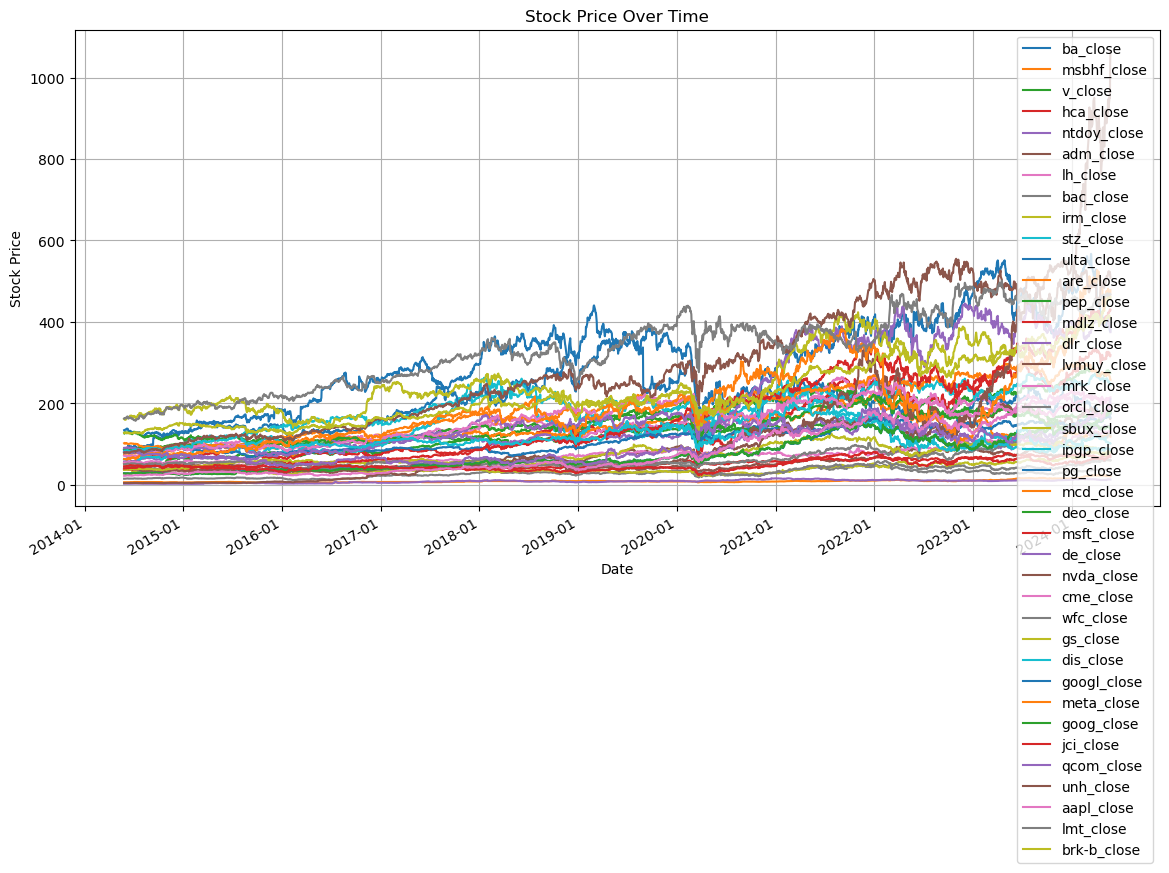

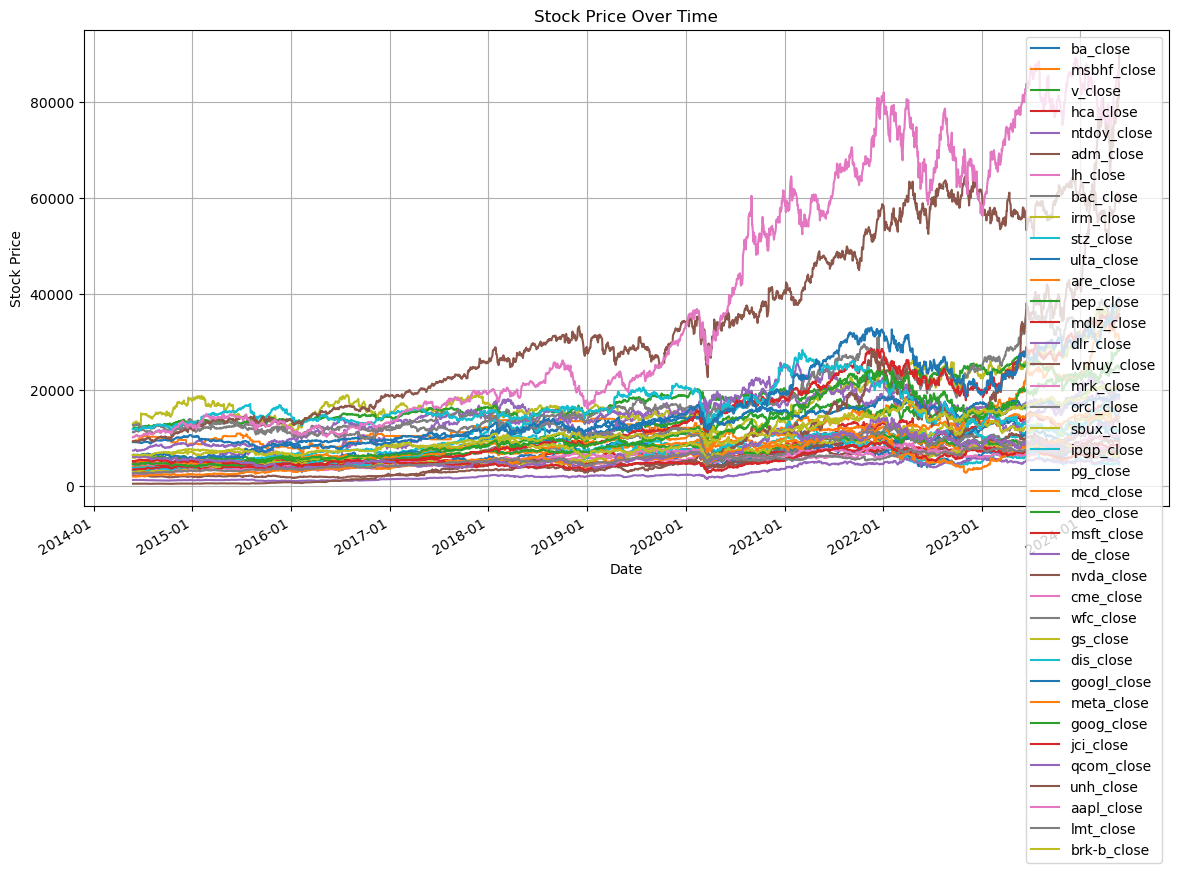

In [54]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot each stock's closing price
for column in portfolio.columns:
    ax.plot(portfolio[column], label=column)

# Add legend
ax.legend()

# Format x-ticks
ax.xaxis.set_major_locator(mdates.YearLocator())  # Display one tick per year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format the date as 'YYYY-MM'

# Rotate date labels automatically
fig.autofmt_xdate()

# Set title and labels
ax.set_title('Stock Price Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')

# Enable grid
ax.grid(True)

# Show plot
plt.show()


# Create a plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot each stock's closing price
for column in portfolio.columns:
    ax.plot(portfolio[column]*equity_quantity[(column.upper()).split('_')[0]], label=column)

# Add legend
ax.legend()

# Format x-ticks
ax.xaxis.set_major_locator(mdates.YearLocator())  # Display one tick per year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format the date as 'YYYY-MM'

# Rotate date labels automatically
fig.autofmt_xdate()

# Set title and labels
ax.set_title('Stock Price Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')

# Enable grid
ax.grid(True)

# Show plot
plt.show()


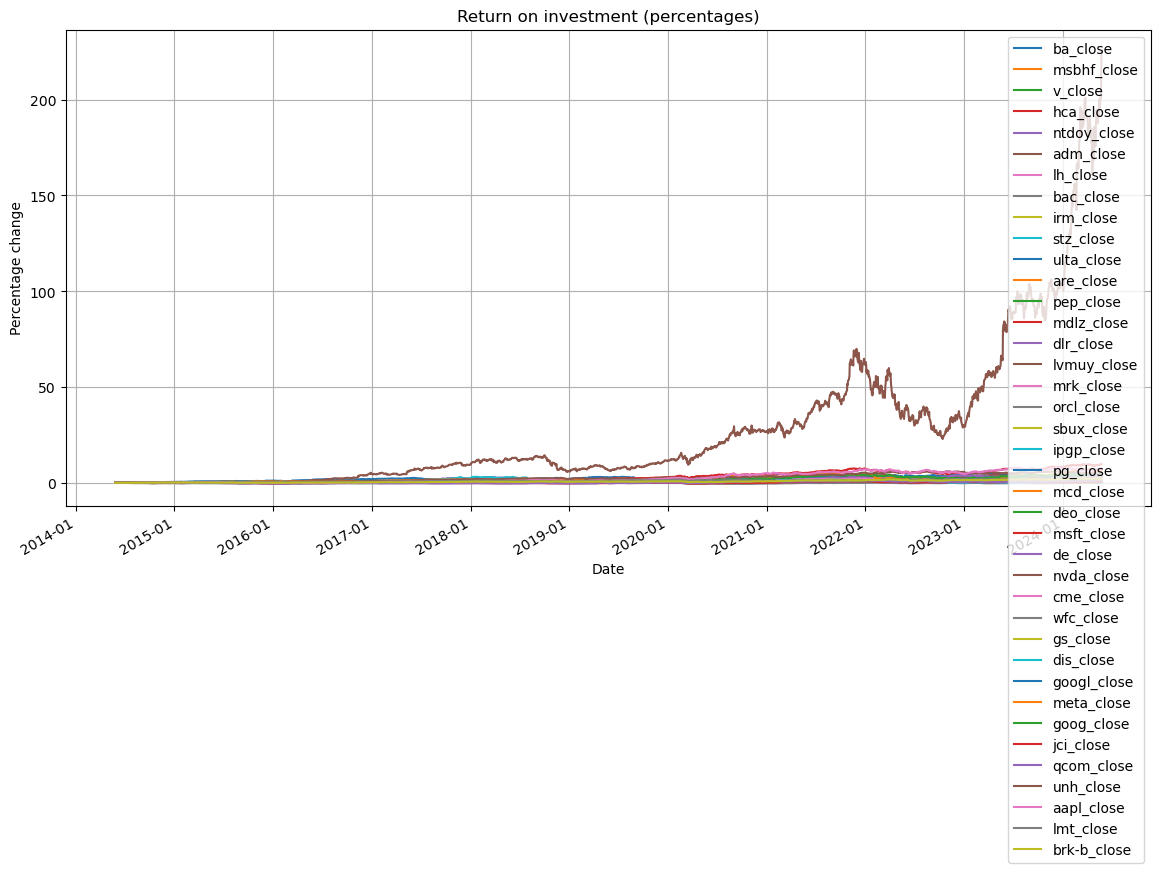

In [56]:
fig, ax = plt.subplots(figsize=(14, 7))

# Normalize and plot each stock's closing price
for column in portfolio.columns:
    initial_value = portfolio[column].iloc[0]
    normalized_line = (portfolio[column] - initial_value) / initial_value
    ax.plot(normalized_line, label=column)

ax.legend()

# Format x-ticks
ax.xaxis.set_major_locator(mdates.YearLocator())  # to display one tick per year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # to format the date as 'YYYY-MM'

# Rotate date labels automatically
fig.autofmt_xdate()

ax.set_title('Return on investment (percentages)')
ax.set_xlabel('Date')
ax.set_ylabel('Percentage change')
ax.grid(True)

plt.show()

returns shape: (2518, 39)
(After Optim) initial portfolio values: 46.90859264106166
(After Optim) final portfolio values: 10614.900474262482


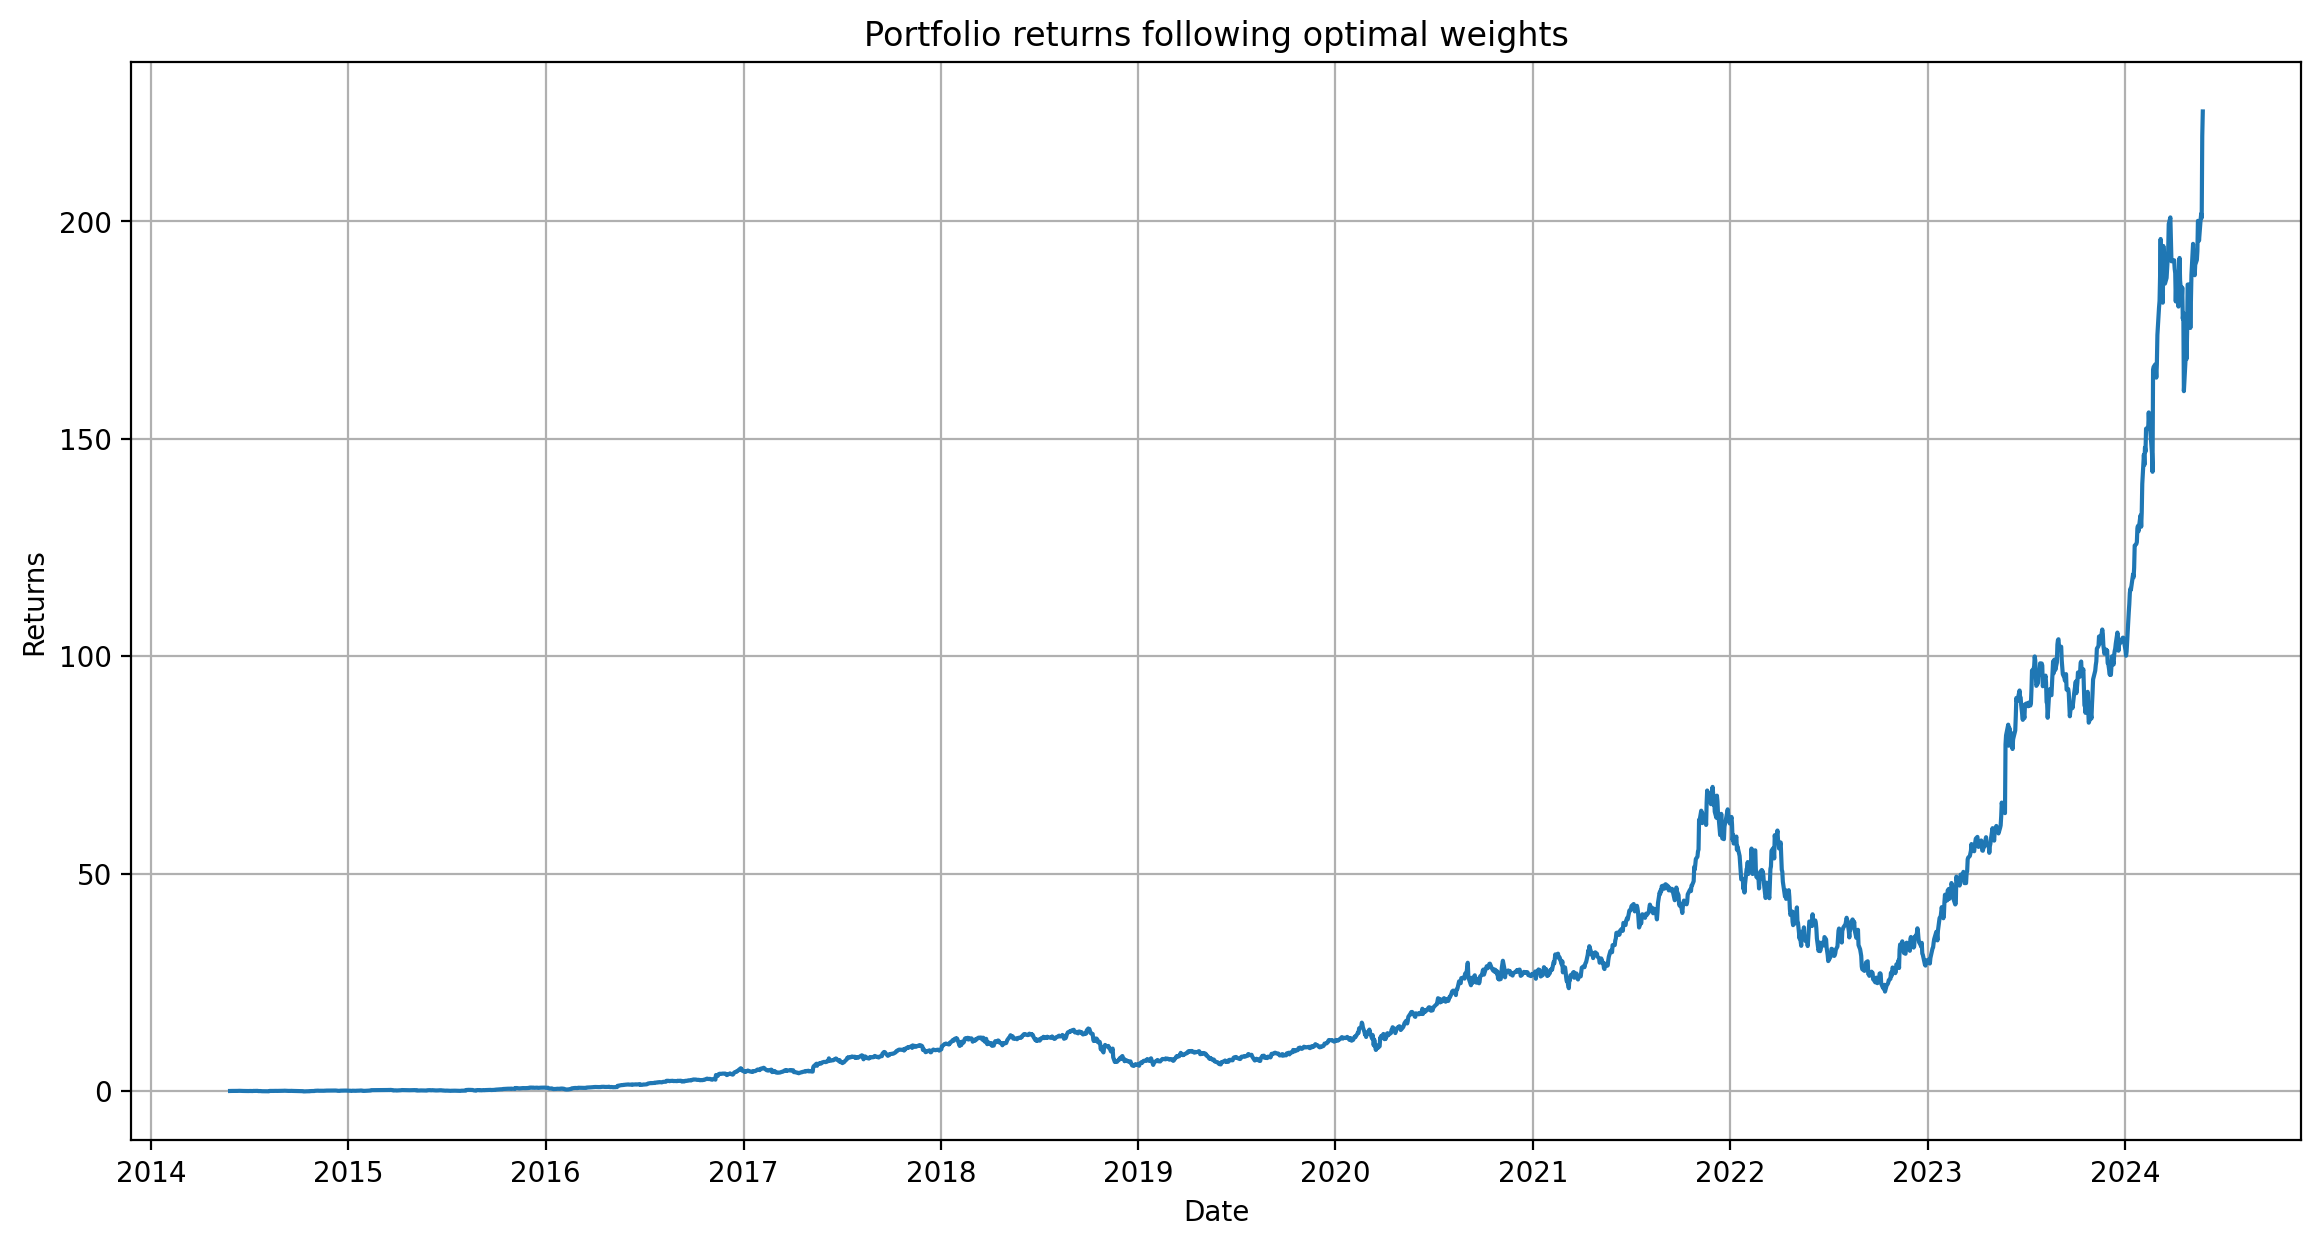

mean returns: ba_close       0.105360
msbhf_close    0.154900
v_close        0.193413
hca_close      0.233176
ntdoy_close    0.222003
adm_close      0.067267
lh_close       0.118103
bac_close      0.143657
irm_close      0.145684
stz_close      0.141017
ulta_close     0.218573
are_close      0.077894
pep_close      0.089383
mdlz_close     0.082469
dlr_close      0.127955
lvmuy_close    0.185436
mrk_close      0.110121
orcl_close     0.142965
sbux_close     0.111634
ipgp_close     0.111632
pg_close       0.089399
mcd_close      0.112974
deo_close      0.029280
msft_close     0.273973
de_close       0.184257
nvda_close     0.653806
cme_close      0.139455
wfc_close      0.064319
gs_close       0.144737
dis_close      0.057436
googl_close    0.220275
meta_close     0.272802
goog_close     0.222932
jci_close      0.083260
qcom_close     0.160136
unh_close      0.218893
aapl_close     0.254529
lmt_close      0.130102
brk-b_close    0.134769
dtype: float64
cov_matrix:              ba_close  

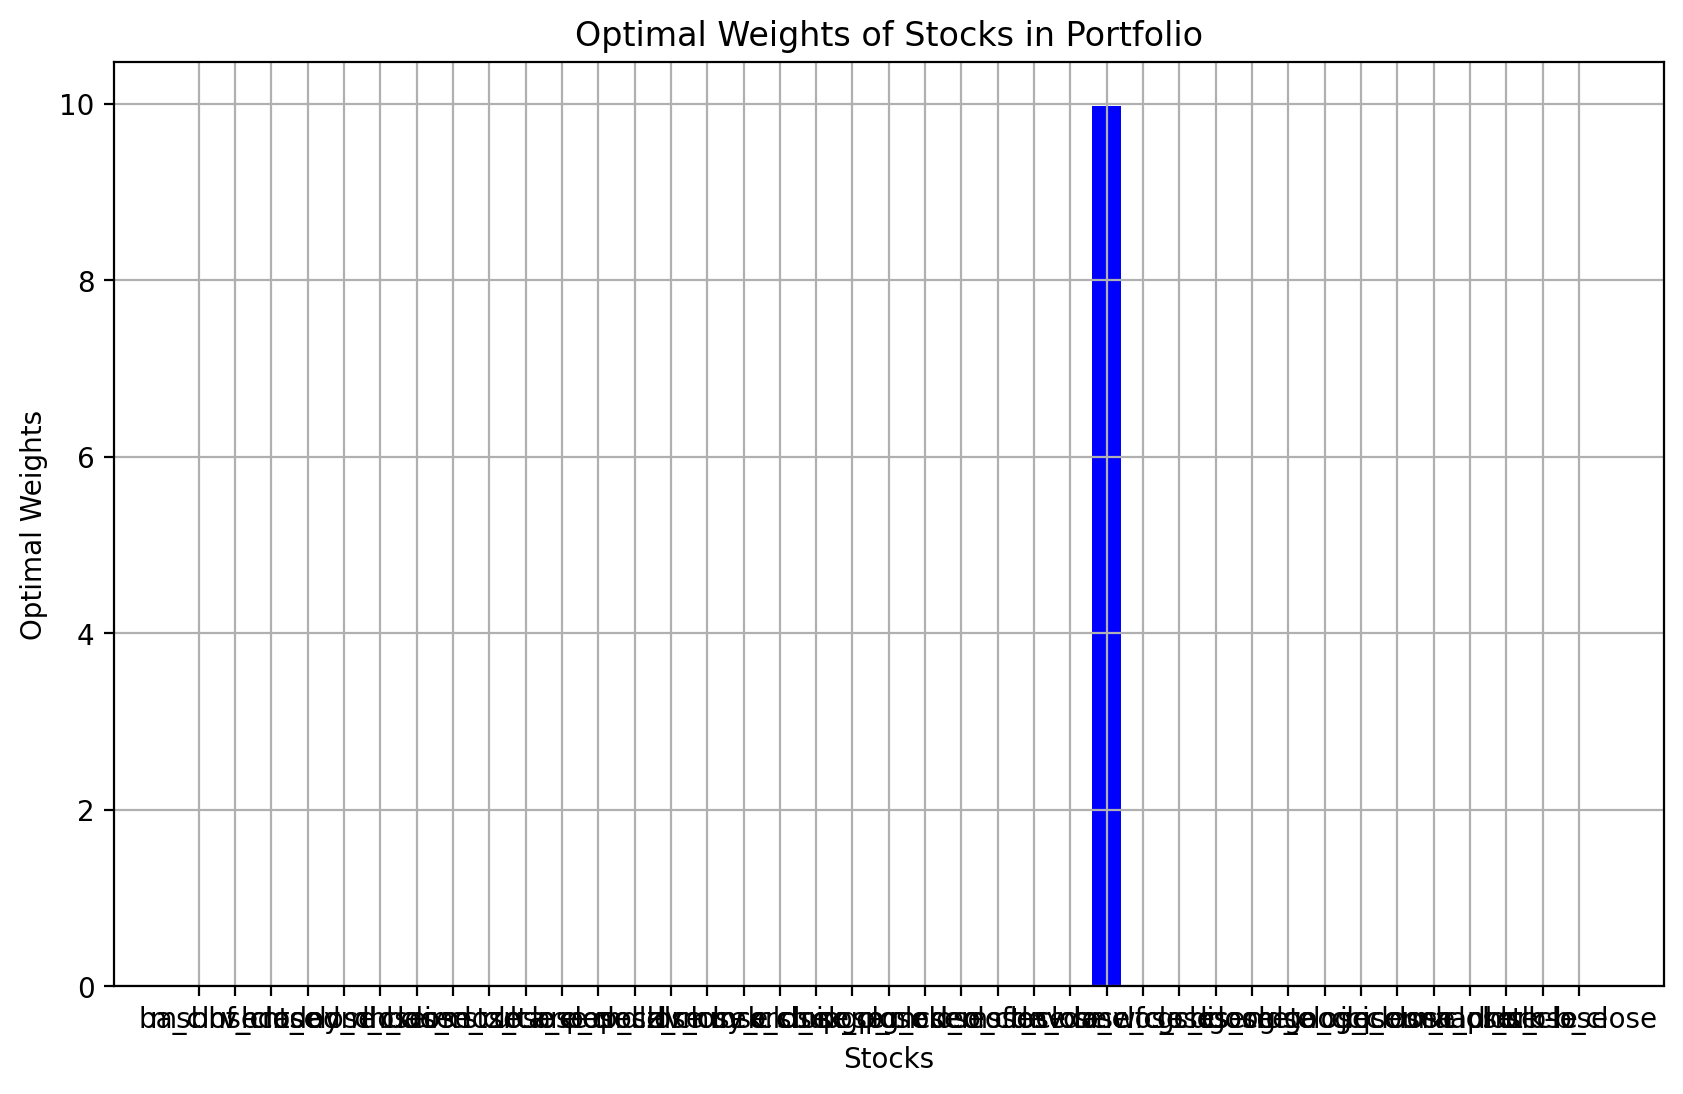

Main Stock Chosen: nvda_close


In [127]:
from scipy.optimize import minimize

# Assume we have price data in a pandas DataFrame called 'portfolio'
# returns are in percentage
returns = portfolio.pct_change()

print(f"returns shape: {returns.shape}")

#! Let's set a target return of 9.0 (900%)
target_return = 5.0

# Calculate mean returns and covariance matrix
#! 252 is used to annualize the data (252 trading days in the US)
mean_returns = returns.mean() * 252
# mean_returns = daily_returns_pct_change.mean()
cov_matrix = returns.cov() * 252

# Define the objective function (portfolio variance)
def objective(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Define the constraint (portfolio return should be equal to the target return)
def constraint1(weights):
    return np.sum(mean_returns * weights) - target_return

# Define the constraint (the sum of the weights should be equal to 1)
def constraint2(weights):
    return np.sum(weights) - 1


# Define the bounds and constraints for the optimization
bounds = tuple((0,1000) for x in range(num_stocks))
#bounds = tuple((0,1) for x in range(num_stocks))
constraints = ({'type': 'eq', 'fun': constraint1},
               {'type': 'eq', 'fun': constraint2})

# Perform the optimization
#print(equity_quantity[(column.upper()).split('_')[0]] for column in portfolio.columns)
initial_weights = [equity_quantity[(column.upper()).split('_')[0]] for column in portfolio.columns] #
#initial_weights = np.ones(num_stocks) /num_stocks

result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)

# Get the optimal portfolio weights
optimal_weights = result.x

# print(f"num stocks: {num_stocks}")
# print(f"result type: {type(result)}")
# print(f"result: {result}")
# print(f"optimal_weights: {optimal_weights}")
# print(f"initial portfolio values: {portfolio.iloc[0, :]}")
# print(f"final portfolio values: {portfolio.iloc[-1, :]}")

#! setting too small values to zero
for i in range(len(optimal_weights)):
    if optimal_weights[i] < 1e-5:
        optimal_weights[i] = 0


portfolio_returns = np.dot(portfolio, optimal_weights)
portfolio_returns_pct_change = (portfolio_returns - portfolio_returns[0]) / portfolio_returns[0]
print(f"(After Optim) initial portfolio values: {portfolio_returns[0]}")
print(f"(After Optim) final portfolio values: {portfolio_returns[-1]}")

# Plot the portfolio returns

fig2, ax2 = plt.subplots(figsize=(14, 7))

ax2.plot(portfolio.index, portfolio_returns_pct_change)
ax2.set_title("Portfolio returns following optimal weights")
ax2.set_xlabel('Date')
ax2.set_ylabel('Returns')
ax2.grid(True)
plt.show()

print(f"mean returns: {mean_returns}")
print(f"cov_matrix: {cov_matrix}")


import matplotlib.pyplot as plt
print(optimal_weights)
# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(portfolio.columns, optimal_weights, color='blue')
plt.xlabel('Stocks')
plt.ylabel('Optimal Weights')
plt.title('Optimal Weights of Stocks in Portfolio')
#plt.ylim(0, 1)  # Assuming weights are between 0 and 1
plt.grid(True)

# Display the bar chart
plt.show()

argmax = np.argmax(optimal_weights)
print(f"Main Stock Chosen: {portfolio.columns[argmax]}")


Neural Network based on MVO (Work in progress for this point onwards)

Setup:

In [90]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
# Comment it if you are not using mac
%config InlineBackend.figure_format = 'retina'

def calculate_total_initial_value(portfolio, equity_quantity):
    total_initial_value = 0
    for column in portfolio.columns:
        stock_name = column.upper().split('_')[0]
        #print(stock_name)
        if stock_name in equity_quantity:
            initial_price = portfolio[column].iloc[0]
            #print(initial_price)
            quantity = equity_quantity[stock_name]
            total_initial_value += initial_price * quantity
    return total_initial_value

total_initial_value = calculate_total_initial_value(portfolio, equity_quantity)
print(f"Total Initial Value: {total_initial_value}")

def calculate_total_final_value(portfolio, equity_quantity):
    total_initial_value = 0
    for column in portfolio.columns:
        stock_name = column.upper().split('_')[0]
        #print(stock_name)
        if stock_name in equity_quantity:
            initial_price = portfolio[column].iloc[-1]
            #print(initial_price)
            quantity = equity_quantity[stock_name]
            total_initial_value += initial_price * quantity
    return total_initial_value


total_final_value = calculate_total_final_value(portfolio, equity_quantity)
print(f"Total Initial Value: {total_final_value}")

# use this plot function to plot the training loss and test loss
def plot(train_loss, test_loss):
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    ax.plot(train_loss, label='train_loss')
    ax.plot(test_loss, label='test_loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Iterations')
    ax.legend()
    plt.show()

Total Initial Value: 217333.350549
Total Initial Value: 796962.5495290002


In [91]:
import time

def loss_func(y_pred, y):
    calculate_total_final_value(portfolio,y_pred) - calculate_total_final_value(portfolio,y) 

def train(model, dataloader, loss_func, device):
    model.train()
    total_mse, total_count = 0, 0
    log_interval = 100
    start_time = time.time()

    for idx, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()

        y_pred = model(X)
        loss = loss_func(y_pred, y)
        loss.backward()

        optimizer.step()
        total_mse += loss.item()
        total_count += X.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| MSE {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_mse/total_count))
            total_mse, total_count = 0, 0
            start_time = time.time()

def evaluate(model, dataloader, loss_func, device, normalize=True):
    model.eval()
    total_mse, total_count = 0, 0

    with torch.no_grad():
        for idx, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)

            ###########################################################################
            # TODO: compute the prediction of the input, get the loss.                #
            # If normlize the data, multiply the prediction value and true value by its range
            ###########################################################################
            y_pred = model(X)
            if normalize:
                y_pred[:,0] *= 30
                y_pred[:,1] *= 2000
                y[:,0] *= 30
                y[:,1] *= 2000
            loss = loss_func(y_pred, y)

            ###########################################################################
            #                             END OF YOUR CODE                            #
            ###########################################################################

            total_mse += loss.item()
            total_count += X.size(0)
    return total_mse/total_count

In [95]:
class SimpleNetwork(nn.Module):
    """
    A simple one-layer neural network with an activation function.
    """
    def __init__(self, input_dim, output_dim):
        """
        Inputs:
        - input_dim: Input dimension
        - ff_dim: Hidden dimension
        """
        super(SimpleNetwork, self).__init__()

        ###########################################################################
        # TODO: Define the two linear layers and a non-linear one.
        ###########################################################################
        self.linear1 = nn.Linear(input_dim,output_dim)
        self.nonlinear = nn.ReLU() 

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

    def forward(self, x: torch.Tensor):
        """
        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
         and C is the channel dimension

        Return:
        - y: Tensor of the shape BxLxC
        """

        y = None
        ###########################################################################
        # TODO: Process the input.                                                #
        ###########################################################################
        y = self.nonlinear(self.linear1(x)) #X is equity quantity
        
        new_total_initial_value = calculate_total_initial_value(portfolio, y)
        y = y*(total_initial_value/new_total_initial_value)

        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################

        return x


In [97]:
dim = 39
model = SimpleNetwork(input_dim=dim, output_dim=dim)

#TO DO:
#Mean is daily closing price
#Covariance assume constant for all days for the same stocks
#Create samples based on: 
#input: daily closing price for basket of stocks, covariance per stock (constant), maybe quantity?
#output: 

def createSamples(data, lookBack, normalize=False): #TO UPDATE FOR OUR USE CASE
    dataX = []
    dataY = []
    temp, co2, people, u1, u2, amb = data['temp'], data['co2'], data['d'], data['u1'], data['u2'], data['amb']
    if normalize:
        # divide variable of its range
        temp /= 30
        co2 /= 2000
        people /= 100
        u1 /= 30
        u2 /= 20
        amb /= 30
    B, T = temp.shape
    u1 = np.repeat(u1, T, axis=1)
    u2 = np.repeat(u2, T, axis=1)
    for t in range(T-lookBack):
        x = np.stack([temp[:,t:t+lookBack], co2[:,t:t+lookBack], people[:,t:t+lookBack], u1[:,t:t+lookBack], u2[:,t:t+lookBack], amb[:,t:t+lookBack]], axis=-1)
        y = np.concatenate([temp[:,t+lookBack:t+lookBack+1], co2[:,t+lookBack:t+lookBack+1]], axis=1)
        dataX.append(x)
        dataY.append(y)
    X = np.concatenate(dataX, axis=0)
    Y = np.concatenate(dataY, axis=0)
    return Tensor(X), Tensor(Y)

# Change normalize bool variable to get raw data or normalized data
X = Tensor()
X, y = createSamples(data, lookBack=24, normalize=True)
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


torch.random.manual_seed(42) #anwer to the question of the universe
epochs = 200 # epoch

for epoch in range(1, epochs + 1, 1):
    epoch_start_time = time.time()
    train(model, train_dataloader, loss_func, device, 1)
    mse_val = evaluate(model, valid_dataloader, loss_func, device, normalize=True)

    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid mse {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           mse_val))
    #print('-' * 59)

NameError: name 'data' is not defined